# Importer le jeu de données MNIST

In [1]:
# load MNIST dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Vérifier la distribution des classes
Nous observons une distribution légèrement non-uniforme, mais rien de bien problématique.

Text(0, 0.5, 'Poucentage du jeu de données (%)')

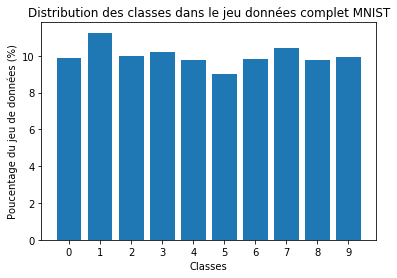

In [2]:
# class imbalance
a = np.unique(y, return_counts=True)
plt.bar(a[0],a[1]/a[1].sum()*100) 
plt.title('Distribution des classes dans le jeu données complet MNIST')
plt.xlabel('Classes')
plt.ylabel('Poucentage du jeu de données (%)')

# Normalisation des caractéristiques
Normalisation des caractéristiques du jeu de données afin de passer d'une échelle de [0,255] à une échelle de [0,1].

In [3]:
# normalize features
X = X/255

# Échantillonnage du jeu de données
Sélection d'un échantillon tiré de façon aléatoire sans répétition de la taille désirée à partir du jeu de données MNIST complet.

In [4]:
# only use a sample of the data
np.random.RandomState(0)
inds = np.random.choice(X.shape[0], 1000, replace=False)
X_sample = X[inds, :]
y_sample = y[inds]

# Vérifier la distribution des classes pour l'échantillon
Étant donné que l’échantillon utilisé de 1 000 exemples tirés aléatoirement est trop petit pour refléter la distribution du jeu de données complet de manière satisfaisante, la distribution des classes dans l’échantillon est encore moins uniforme.


Text(0, 0.5, 'Poucentage du jeu de données (%)')

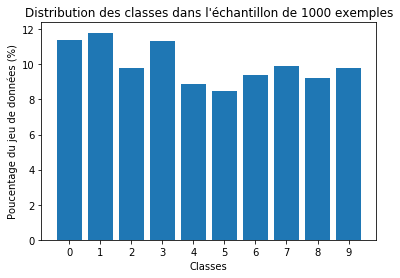

In [5]:
# class imbalance
a = np.unique(y_sample, return_counts=True)
plt.bar(a[0],a[1]/a[1].sum()*100) 
plt.title("Distribution des classes dans l'échantillon de 1000 exemples")
plt.xlabel('Classes')
plt.ylabel('Poucentage du jeu de données (%)')

# Visualisation d'images
Code pour visualiser les exemples désirés issus de l'échantillon.

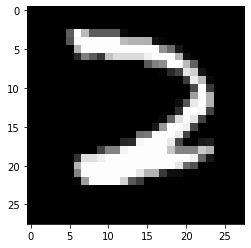

In [6]:
# Visualize examples from our sample
pixels = X_sample[5].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

# Mesure de similarité originale 1: Buffered pixel mapping
Ce code se charge de:
Transformer les exemples reçus en entrées de vecteurs de 784 dimensions en matrices de dimensions 28x28. Cette étape sert à faciliter les opérations subséquentes sur ces exemples.

Faire une liste de l’emplacement de tous les pixels qui sont plus foncés qu’une valeur fournie en entrée (hyperparamètre nommé ‘’Binary threshold’’). Seulement les pixels dans cette liste seront considérés pour le restant du code. Les autres pixels sont considérés comme complètement blancs.

Identifier la liste (parmi les deux listes) qui compte le plus de pixels foncés et lui assigner la première position (liste1). Cette étape sert à assurer que les mesures soient pseudo-symétriques, une condition requise afin de pouvoir construire une matrice de distance. Elle sert également d’heuristique afin de minimiser les erreurs de comparaisons entre les images reçues en entrées. La structure de nos mesures, par exemple, les poussent à reconnaître 3 comme étant un 8 si les images sont comparées en partant du 3. Le cas contraire n’engendre, par contre, aucun problème de ce type. Ceci est dû au fait que la forme d’un 3 est comprise dans la forme d’un 8, mais pas l’inverse.

Localiser le centroïde des deux listes de pixels foncés et les recentrer au même point, soit l’emplacement du centroïde de la liste1. Cette étape sert à aligner le plus possible les agrégats de pixels foncés qui constituent les deux images comparées (c.-à-d. centrer les deux chiffres l’un sur l’autre).

Ajouter une couche de pixels foncés qui entoure l'agrégat de pixels foncés déjà contenu dans la liste2 (la liste de pixels la plus courte). ‘’L’épaisseur’’ de la couche ajoutée représente un second hyperparamètre nommé ‘’Buffer radius’’. Cette étape sert à intégrer une ‘’marge d’erreur’’ autour du deuxième chiffre comparé afin d’augmenter les probabilités que les pixels foncés des deux chiffres comparés se chevauchent (c.-à.d. qu’ils partagent les mêmes coordonnées sur leur images respectives).

Transformer les coordonnées à deux dimensions des pixels dans les deux listes de pixels foncés en scalaires à une dimension tout en préservant toute l’information contenue dans les coordonnées. Cette étape ‘’aplati’’ les listes, qui sont sous forme de matrice, en vecteurs afin de faciliter l’étape suivante.

Calculer le pourcentage de pixels foncés dans la liste1 qui ne sont pas également dans la liste2 (c.-à-d. vérifier pour chaque pixel dans la liste 1 si un pixel foncé existe au même emplacement dans la liste2). Le résultat engendré par ce calcul représente le pourcentage de pixels de la liste1 qui ne chevauchent pas les pixels de la liste2. Deux images similaires, dont la plupart des pixels se chevauchent, vont donc engendrer un petit résultat, alors que deux images très différentes vont engendrer un grand résultat.



In [7]:
# similarity measure 1

def buffered_pixel_mapping(x1, x2, buffer_radius=0, binary_threshold=1):
    threshold = binary_threshold/255
    
    # reshape arrays into 28x28
    x1 = np.reshape(x1, (28,28))
    x2 = np.reshape(x2, (28,28))
    
    # only look at dark pixels
    dark_x1 = np.array(np.where(x1 > threshold))
    dark_x2 = np.array(np.where(x2 > threshold))
    
    # choose darwing with the most dark pixels as reference
    if dark_x2.shape[0] > dark_x1.shape[0] or (dark_x2.shape[0] == dark_x1.shape[0] and dark_x1.sum()<dark_x2.sum()):
        temp = dark_x2.copy()
        dark_x2 = dark_x1.copy()
        dark_x1 = temp.copy()    
        
    # align image centroids
    dark_x1 = dark_x1.T
    dark_x2 = dark_x2.T
    
    dark_x1_centroid = ((dark_x1.max(axis=0) - dark_x1.min(axis=0)) / 2) + dark_x1.min(axis=0)
    dark_x2_centroid = ((dark_x2.max(axis=0) - dark_x2.min(axis=0)) / 2) + dark_x2.min(axis=0)
    
    translation = (dark_x1_centroid - dark_x2_centroid).round(decimals=0)
    dark_x2 = dark_x2 + translation

    # add a buffer around dark_x2 drawing
    for i in range(buffer_radius):
        dark_x2 = np.concatenate([dark_x2, dark_x2 + [i+1,0]], axis=0)
        dark_x2 = np.concatenate([dark_x2, dark_x2 - [i+1,0]], axis=0)
        dark_x2 = np.concatenate([dark_x2, dark_x2 + [0,i+1]], axis=0)
        dark_x2 = np.concatenate([dark_x2, dark_x2 - [0,i+1]], axis=0)
    
    # flatten arrays
    dark_x1[:,0] = dark_x1[:,0]*28
    pixel_sequence_x1 = dark_x1.sum(axis=1)
    
    dark_x2[:,0] = dark_x2[:,0]*28
    pixel_sequence_x2 = dark_x2.sum(axis=1)
    
    # compare pixels in x1 to pixels in x2
    similarity = np.around((pixel_sequence_x1.shape[0] - np.isin(pixel_sequence_x1, pixel_sequence_x2).astype(int).sum()) / pixel_sequence_x1.shape[0], decimals = 6)
    
    return similarity

# Mesure de similarité originale 2: Average nearest pixel
Ce code se charge de: 
Transformer les exemples reçus en entrées de vecteurs de 784 dimensions en matrices de dimensions 28x28. Cette étape sert à faciliter les opérations subséquentes sur ces exemples.

Faire une liste de l’emplacement de tous les pixels qui sont plus foncés qu’une valeur fournie en entrée (hyperparamètre nommé ‘’Binary threshold’’). Seulement les pixels dans cette liste seront considérés pour le restant du code. Les autres pixels sont considérés comme complètement blancs.

Identifier la liste (parmi les deux listes) qui compte le plus de pixels foncés et lui assigner la première position (liste1). Cette étape sert à assurer que les mesures soient pseudo-symétriques, une condition requise afin de pouvoir construire une matrice de distance. Elle sert également d’heuristique afin de minimiser les erreurs de comparaisons entre les images reçues en entrées. La structure de nos mesures, par exemple, les poussent à reconnaître 3 comme étant un 8 si les images sont comparées en partant du 3. Le cas contraire n’engendre, par contre, aucun problème de ce type. Ceci est dû au fait que la forme d’un 3 est comprise dans la forme d’un 8, mais pas l’inverse.

Localiser le centroïde des deux listes de pixels foncés et les recentrer au même point, soit l’emplacement du centroïde de la liste1. Cette étape sert à aligner le plus possible les agrégats de pixels foncés qui constituent les deux images comparées (c.-à-d. centrer les deux chiffres l’un sur l’autre).

Pour chaque pixel foncé dans la liste1, calculer la distance au pixel de la liste2 avec les coordonnées les plus rapprochées. La distance calculée représente la distance euclidienne au carré appliquée aux coordonnées des paires de pixels dans le cadre de l’image de taille 28x28 pixels. Étant donné que cette distance est au carré, elle pénalise fortement les pixels situés loins l’un de l’autre. Une fois, la distance minimale pour chaque pixel foncé de la liste1 aux pixels de la liste2 calculée, la moyenne de ces distances minimales sur la liste1 est renvoyée comme résultat. Deux images similaires, dont les pixels sont généralement rapprochés, vont donc engendrer un petit résultat, alors que deux images très différentes vont engendrer un grand résultat.

In [8]:
# similarity measure 2

def avg_nearest_pixel(x1, x2, binary_threshold=1):
    threshold = binary_threshold/255
    
    # reshape arrays into 28x28
    x1 = np.reshape(x1, (28,28))
    x2 = np.reshape(x2, (28,28))
    
    # only look at dark pixels
    dark_x1 = np.array(np.where(x1 > threshold))
    dark_x2 = np.array(np.where(x2 > threshold))
    
    # choose darwing with the most dark pixels as reference
    if dark_x2.shape[0] > dark_x1.shape[0] or (dark_x2.shape[0] == dark_x1.shape[0] and dark_x1.sum()<dark_x2.sum()):
        temp = dark_x2.copy()
        dark_x2 = dark_x1.copy()
        dark_x1 = temp.copy()    
        
    # align image centroids
    dark_x1 = dark_x1.T
    dark_x2 = dark_x2.T
    
    dark_x1_centroid = ((dark_x1.max(axis=0) - dark_x1.min(axis=0)) / 2) + dark_x1.min(axis=0)
    dark_x2_centroid = ((dark_x2.max(axis=0) - dark_x2.min(axis=0)) / 2) + dark_x2.min(axis=0)
    
    translation = dark_x1_centroid - dark_x2_centroid
    dark_x2 = dark_x2 + translation
    
    # find min distances for each point and sum up
    def fct(x):
        return np.min(((dark_x2-x)**2).sum(axis=1))

    # return mean minimum distance for all points of dark_x1
    return np.apply_along_axis(fct, 1, dark_x1).sum() / dark_x1.shape[0]

# Matrice de distance
Ce code nous permet de facilement générer des matrices de distance pour usage avec nos deux mesures originales.

In [9]:
# define custom distance matrix

import scipy
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

def distance_matrix(X, fct): 
    mat = pdist(X, lambda u, v: fct(u, v))
    return scipy.spatial.distance.squareform(mat)

# PCoA
Nous implémentons premièrement l'algorithme PCoA avec 2 composantes en utilisant la distance euclédienne et visualisons le résultat à l'aide d'un scatter plot.

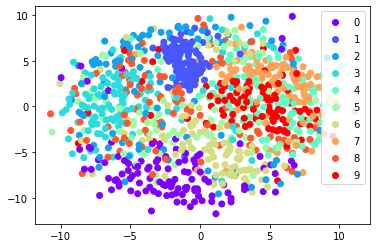

In [10]:
# ___PCoA___

# euclidian distance
from sklearn.manifold import MDS
PCoA = MDS(n_components=2, metric=True, dissimilarity='euclidean', random_state=0)
X_sample_PCoA = PCoA.fit_transform(X_sample)

scatter = plt.scatter(X_sample_PCoA[:, 0], X_sample_PCoA[:, 1], c=y_sample.astype(int), cmap='rainbow')
plt.legend(*scatter.legend_elements())

Nous implémentons l'algorithme PCoA avec 2 composantes en utilisant notre mesure de similarité BPM et visualisons le résultat à l'aide d'un scatter plot. Nous devons changer les hyperparamètres à partir de la fonction ''buffered_pixel_mapping'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

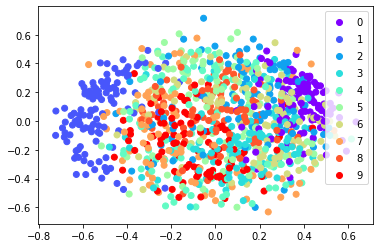

In [11]:
# similarity measure 1
dist_mat = distance_matrix(X_sample, buffered_pixel_mapping)

PCoA = MDS(n_components=2, metric=True, dissimilarity='precomputed', random_state=0)
X_sample_PCoA = PCoA.fit_transform(dist_mat)

scatter = plt.scatter(X_sample_PCoA[:, 0], X_sample_PCoA[:, 1], c=y_sample.astype(int), cmap='rainbow')
plt.legend(*scatter.legend_elements())

Nous implémentons l'algorithme PCoA avec 2 composantes en utilisant notre mesure de similarité ANP et visualisons le résultat à l'aide d'un scatter plot. Nous devons changer les hyperparamètres à partir de la fonction ''avg_nearest_pixel'' afin de récolter des résultats pour les différentes valeurs désirées pour l'hyperparamètre ''binary threshold''.

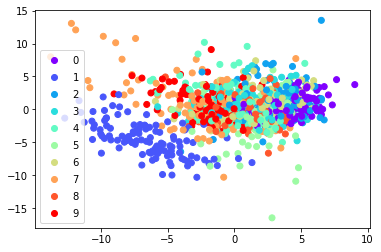

In [12]:
# similarity measure 2
dist_mat = distance_matrix(X_sample, avg_nearest_pixel)

PCoA = MDS(n_components=2, metric=True, dissimilarity='precomputed', random_state=0)
X_sample_PCoA = PCoA.fit_transform(dist_mat)

scatter = plt.scatter(X_sample_PCoA[:, 0], X_sample_PCoA[:, 1], c=y_sample.astype(int), cmap='rainbow')
plt.legend(*scatter.legend_elements())

# Isomap
Nous implémentons premièrement l'algorithme Isomap avec 2 composantes en utilisant la distance euclédienne et visualisons le résultat à l'aide d'un scatter plot. Nous avons utilisé un nombre de voisins = 2 pour toutes les implémentations afin de comparer les mesures de manière la plus équitable possible.

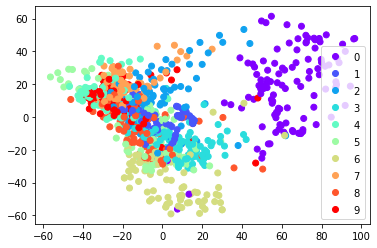

In [13]:
# ___ISOMAP___

# euclidian
from sklearn.manifold import Isomap
isomap = Isomap(n_neighbors=2, n_components=2, neighbors_algorithm='auto')
X_sample_isomap = isomap.fit_transform(X_sample)

scatter = plt.scatter(X_sample_isomap[:, 0], X_sample_isomap[:, 1], c=y_sample.astype(int), cmap='rainbow')
plt.legend(*scatter.legend_elements())

Nous implémentons l'algorithme Isomap avec 2 composantes en utilisant notre mesure de similarité BPM et visualisons le résultat à l'aide d'un scatter plot. Nous devons changer les hyperparamètres à partir de la fonction ''buffered_pixel_mapping'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

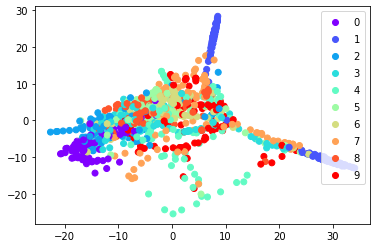

In [14]:
# similarity measure 1
dist_mat = distance_matrix(X_sample, buffered_pixel_mapping)

isomap = Isomap(n_neighbors=2, n_components=2, neighbors_algorithm='auto')
X_sample_isomap = isomap.fit_transform(dist_mat)

scatter = plt.scatter(X_sample_isomap[:, 0], X_sample_isomap[:, 1], c=y_sample.astype(int), cmap='rainbow')
plt.legend(*scatter.legend_elements())

Nous implémentons l'algorithme Isomap avec 2 composantes en utilisant notre mesure de similarité ANP et visualisons le résultat à l'aide d'un scatter plot. Nous devons changer les hyperparamètres à partir de la fonction ''avg_nearest_pixel'' afin de récolter des résultats pour les différentes valeurs désirées pour l'hyperparamètre ''binary threshold''.

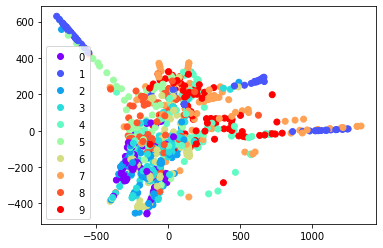

In [15]:
# similarity measure 2
dist_mat = distance_matrix(X_sample, avg_nearest_pixel)

isomap = Isomap(n_neighbors=2, n_components=2, neighbors_algorithm='auto')
X_sample_isomap = isomap.fit_transform(dist_mat)

scatter = plt.scatter(X_sample_isomap[:, 0], X_sample_isomap[:, 1], c=y_sample.astype(int), cmap='rainbow')
plt.legend(*scatter.legend_elements())

# K-médoïde
Nous implémentons premièrement l'algorithme avec la distance euclidienne. Nous devons, à cette fin, calculer une matrice de distances euclidiennes avec tous les exemples MNIST utilisés (i.e. notre échantillon complet) qui est fournie en entrée à l'algorithme afin de l'entrainer. Pour toutes les implémentations de l'algorithme (sur toutes les mesures), nous optons pour 10 médoides afin de refléter les 10 classes présentent dans le jeu de données MNIST.

Cette approche correspond à une utilisation pour laquelle le centroide est l’élément du groupe qui maximise la similarité et pour laquelle un élément est dans le groupe qui maximise sa similarité avec le centroide. 

L'évaluation de la performance est effectuée à l’aide de la mesure V. Nous avons choisi d’utiliser un indice d’évaluation externe étant donné que nous avons accès aux étiquettes du jeu de données, constituant une partition cible qui représente la solution optimale désirée.

In [16]:
# ___K-MEDOIDES___

# use Euclidian distance
from sklearn.metrics.pairwise import euclidean_distances
D = euclidean_distances(X_sample, X_sample)

import pyclustering
from pyclustering.cluster.kmedoids import kmedoids

# run model with 10 clusters
initial_medoids = list(range(10))
kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')

kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()

y_pred = np.zeros(y_sample.shape[0])
for i, cluster in enumerate(clusters):
    y_pred[cluster] = i
    
# measure v-score    
from sklearn.metrics.cluster import v_measure_score
v_measure_score(y_sample, y_pred)

0.39987550657808163

Nous implémentons l'algorithme en utilisant notre mesure de similarité BPM. Nous devons, à cette fin, calculer une matrice de distances à l'aide de la fonction définie précédemment et tous les exemples MNIST utilisés (i.e. notre échantillon complet) qui est fournie en entrée à l'algorithme afin de l'entrainer.

Nous devons changer les hyperparamètres à partir de la fonction ''buffered_pixel_mapping'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

In [17]:
# mesure 1
dist_mat = distance_matrix(X_sample, buffered_pixel_mapping) 

# run model with 10 clusters
initial_medoids = list(range(10))
kmedoids_instance = kmedoids(dist_mat, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

y_pred = np.zeros(y_sample.shape[0])
for i, cluster in enumerate(clusters):
    y_pred[cluster] = i

# measure v-score
from sklearn.metrics.cluster import v_measure_score
print(v_measure_score(y_sample, y_pred))

0.387994435797617


Nous implémentons l'algorithme en utilisant notre mesure de similarité ANP. Nous devons, à cette fin, calculer une matrice de distances à l'aide de la fonction définie précédemment et tous les exemples MNIST utilisés (i.e. notre échantillon complet) qui est fournie en entrée à l'algorithme afin de l'entrainer.

Nous devons changer les hyperparamètres à partir de la fonction ''avg_nearest_pixel'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

In [18]:
# mesure 2
dist_mat = distance_matrix(X_sample, avg_nearest_pixel)

# run model with 10 clusters
initial_medoids = list(range(10))
kmedoids_instance = kmedoids(dist_mat, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

y_pred = np.zeros(y_sample.shape[0])
for i, cluster in enumerate(clusters):
    y_pred[cluster] = i

# measure v-score
from sklearn.metrics.cluster import v_measure_score
print(v_measure_score(y_sample, y_pred))

0.416425210328091


# Partition binaire
Nous implémentons premièrement l'algorithme de partition binaire avec la distance euclidienne. Pour toutes les implémentations de l'algorithme (sur toutes les mesures), nous optons pour 10 groupes de partitionnement afin de refléter les 10 classes présentent dans le jeu de données MNIST et nous utilisons la variation basée sur la moyenne des distances. 

L'évaluation de la performance est effectuée à l’aide de la mesure V. Nous avons choisi d’utiliser un indice d’évaluation externe étant donné que nous avons accès aux étiquettes du jeu de données, constituant une partition cible qui représente la solution optimale désirée.

In [19]:
# ___PARTITION BINAIRE___

from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='average')
clustering.fit(X_sample)
y_pred = clustering.labels_

# measure v-score    
from sklearn.metrics.cluster import v_measure_score
v_measure_score(y_sample, y_pred)

0.2378955982059238

Nous implémentons l'algorithme en utilisant notre mesure de similarité BPM. Nous devons, à cette fin, calculer une matrice de distances à l'aide de la fonction définie précédemment et tous les exemples MNIST utilisés (i.e. notre échantillon complet) qui est fournie en entrée à l'algorithme afin de l'entrainer.

Nous devons changer les hyperparamètres à partir de la fonction ''buffered_pixel_mapping'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

In [20]:
# mesure 1
dist_mat = distance_matrix(X_sample, buffered_pixel_mapping)

clustering = AgglomerativeClustering(n_clusters=10, affinity="precomputed", linkage='average')
clustering.fit(dist_mat)
y_pred = clustering.labels_

# measure v-score    
v_measure_score(y_sample, y_pred)

0.2918803704516741

Nous implémentons l'algorithme en utilisant notre mesure de similarité ANP. Nous devons, à cette fin, calculer une matrice de distances à l'aide de la fonction définie précédemment et tous les exemples MNIST utilisés (i.e. notre échantillon complet) qui est fournie en entrée à l'algorithme afin de l'entrainer.

Nous devons changer les hyperparamètres à partir de la fonction ''avg_nearest_pixel'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

In [21]:
# mesure 2
dist_mat = distance_matrix(X_sample, avg_nearest_pixel) # treshold 1

clustering = AgglomerativeClustering(n_clusters=10, affinity="precomputed", linkage='average')
clustering.fit(dist_mat)
y_pred = clustering.labels_

# measure v-score    
v_measure_score(y_sample, y_pred)

0.3896394752501948

# KNN
Avant d'implémenter l'algorithme, nous divisons aléatoirement notre échantillon en ensembles d'entrainement et de test. Nous allouons 80% des exemples à l'ensemble d'entrainement et 20% à l'ensemble de test. Afin de limiter le temps d'exécution lorts de la recherched des meilleurs hyperparamètres (tuning), nous créons également un ensemble de tuning en sélectionnant de manière aléatoire 50% de l'ensemble d'entrainement.

In [22]:
# split training and test dataset + sample training set for model tuning
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=0)
X_tuning, surplus_0, y_tuning, surplus_1 = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

Nous implémentons premièrement l'algorithme avec la distance euclidienne. 

Pour toutes les implémentations (sur toutes les mesures), nous utilisons la validation croisée avec 3-folds afin de sélectionner l'hyperparamètre K (nombre de voisins) qui génère la meilleure performance. La recherche d'hyperparamètre est effectuée à l'aide de l'ensemble de tuning et considère les valeurs de [1,10] pour K. Nous optimisons en vue d'obtenir la meilleure macro-moyenne du score recall possible. Nous avons choisi cette métrique, car elle accorde une même importance à la performance sur chaque classe, quelle que soit la distribution des classes. Ceci est fait afin de contrer les effets (si petits soient-ils) de la non-uniformité de la distribution des classes dans notre échantillon.

Une fois la valeur de K optimale trouvée, nous entrainons l'algorithme sur l'ensemble d'entrainement et prédisons les étiquettes pour l'ensemble test.

Nous comparons les prédictions sur l'ensemble test avec les vraies étiquettes de cet ensemble et calculons la macro-moyenne du score recall pour ces valeurs.

In [23]:
# ___KNN___

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

# model tuning using 3 fold cross-validation for values of K = [1,10]
parameters = {'n_neighbors': range(1,11)}
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='ball_tree', metric='minkowski')

grid = GridSearchCV(knn, parameters, cv=3, scoring='recall_macro', n_jobs=-1)
grid.fit(X_tuning, y_tuning)

# train model using best value of K + make predictions on test set
knn.set_params(n_neighbors=grid.best_params_['n_neighbors'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# measure macro-averaged recall score
# to give all classes same importance regardless of possible class imbalances
recall_score(y_test, y_pred, average='macro') 

C:\Users\draby\.julia\conda\3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8973056037529723

Afin de pouvoir implémenter l'algorithme KNN avec nos mesures, nous définissons une matrice de distances calculées entre les données de test et les données utilisées pour l'entrainement de l'algorithme.

In [24]:
def test_matrix(x_test, x_train, similarity_mesure):
  test_mat = np.zeros((x_test.shape[0], x_train.shape[0]))

  for i in range(x_test.shape[0]):
    for j in range(x_train.shape[0]):
      test_mat[i,j] = similarity_mesure(x_test[i], x_train[j])
      
  return test_mat

Nous implémentons l'algorithme en utilisant notre mesure de similarité BPM. Nous devons, à cette fin, calculer deux matrices de distances sur les ensembles de tuning et d'entrainement, ainsi qu'une matrice de distance entre les données de test et celles utilisées pour l'entrainement de l'algorithme.

Nous devons changer les hyperparamètres à partir de la fonction ''buffered_pixel_mapping'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

In [25]:
# mesure 1

# compute necessary distance matrices + test matrix
dist_mat_train = distance_matrix(X_train, buffered_pixel_mapping) 
dist_mat_tuning = distance_matrix(X_tuning, buffered_pixel_mapping) 
dist_mat_test = test_matrix(X_test, X_train, buffered_pixel_mapping) 

# select the best k for our model
parameters = {'n_neighbors': range(1,11)}
knn = KNeighborsClassifier(algorithm='auto', metric='precomputed')

grid = GridSearchCV(knn, parameters, cv=3, scoring='recall_macro', n_jobs=-1)
grid.fit(dist_mat_tuning, y_tuning)
grid.best_params_

# train model + make predictions on test set
knn.set_params(n_neighbors=grid.best_params_['n_neighbors'])
knn.fit(dist_mat_train, y_train)
y_pred = knn.predict(dist_mat_test)

# measure macro-averaged recall score
# to give all classes same importance regardless of possible class imbalances
recall_score(y_test, y_pred, average='macro') 

C:\Users\draby\.julia\conda\3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8337645663303558

Nous implémentons l'algorithme en utilisant notre mesure de similarité ANP. Nous devons, à cette fin, calculer deux matrices de distances sur les ensembles de tuning et d'entrainement, ainsi qu'une matrice de distance entre les données de test et celles utilisées pour l'entrainement de l'algorithme.

Nous devons changer les hyperparamètres à partir de la fonction ''avg_nearest_pixel'' afin de récolter des résultats pour les différentes combinaisons d'hyperparamètres désirées.

In [26]:
# mesure 2

# compute necessary distance matrices + test matrix
dist_mat_train = distance_matrix(X_train, avg_nearest_pixel) 
dist_mat_tuning = distance_matrix(X_tuning, avg_nearest_pixel)
dist_mat_test = test_matrix(X_test, X_train, avg_nearest_pixel)

# select the best k for our model
parameters = {'n_neighbors': range(1,11)}
knn = KNeighborsClassifier(algorithm='auto', metric='precomputed')

grid = GridSearchCV(knn, parameters, cv=3, scoring='recall_macro', n_jobs=-1)
grid.fit(dist_mat_tuning, y_tuning)
grid.best_params_

# train model + make predictions on test set
knn.set_params(n_neighbors=grid.best_params_['n_neighbors'])
knn.fit(dist_mat_train, y_train)
y_pred = knn.predict(dist_mat_test)

# measure macro-averaged recall score
# to give all classes same importance regardless of possible class imbalances
recall_score(y_test, y_pred, average='macro') 

C:\Users\draby\.julia\conda\3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8612981438639332